20180524

Adding a censor label for calculation of the C-index and for future train improvements

Adding sample_type_id which must be 01A for the primary tumor

In [1]:
%pylab inline
import pandas as pd
import numpy as np
import fastai
import torch
from pathlib import Path
import PIL
import tqdm
import os
import json
tqdm.monitor_interval = 0

Populating the interactive namespace from numpy and matplotlib


In [2]:
from fastai.conv_learner import resnet34, resnet152, transforms_top_down, CropType, \
    tfms_from_model, ConvLearner, optim, T
from fastai.dataset import ImageClassifierData, Denormalize
from fastai.sgdr import TrainingPhase, DecayType
from lifelines.utils import concordance_index

In [3]:
def cindex_metric(preds, targs):
    try:
        cindex = concordance_index(preds, targs)
    except:
        cindex = 0.0
    return cindex

In [4]:
torch.backends.cudnn.benchmark=True
torch.cuda.set_device(1)
torch.cuda.current_device()


1

In [5]:
LIVER_PATH = Path('/DATA/BIO/GDC/liver')
LIVER_SAMPLES = LIVER_PATH/"samples"
EXP_PATH = LIVER_PATH/"exp1"
EXP_MODEL_PATH = EXP_PATH/"models"
EXP_DATA = EXP_PATH/"data"
EXP_TRAIN_DATA = EXP_DATA/"train"
EXP_TEST_DATA = EXP_DATA/"test"
PATIENT_JSON = EXP_PATH/'patient_split_censor.json'
TRAIN_CSV = EXP_PATH/'level_1_train.csv'
TRAIN_CSV_FULL = EXP_PATH/'level_1_train_full.csv'
TEST_CSV = EXP_PATH/'level_1_test.csv'
TEST_CSV_FULL = EXP_PATH/'level_1_test_FULL.csv'

for d in [EXP_PATH, EXP_DATA, EXP_TRAIN_DATA, EXP_TEST_DATA, EXP_MODEL_PATH]:
    if not d.exists():
        d.mkdir()

In [7]:
slides = pd.read_csv(LIVER_PATH/'slides.csv')
def get_tissue_type(x):
    return x.split('-')[4]
def get_sample_type(x):
    ''' 01A samples are "primary tumor" and we want just those samples'''
    return x.split('-')[3]

tissue_type = slides.slide_file_name.apply(get_tissue_type)
sample_type = slides.slide_file_name.apply(get_sample_type)
slides = slides.loc[(tissue_type == '01') &  (sample_type=='01A'),:].copy()

In [12]:
try:
    with open(PATIENT_JSON, 'r') as fobj:
        patients = json.load(fobj)
        train_patients = patients['train']
        val_patients = patients['val']
        test_patients = patients['test']
    train_slides = slides.loc[slides.submitter_id.isin(train_patients)]
    test_slides = slides.loc[slides.submitter_id.isin(test_patients)]

    train_csv_df = pd.read_csv(TRAIN_CSV_FULL)
    val_idx = train_csv_df.loc[train_csv_df.val_patient].index
except:
    slides['days_proxy'] = slides.days_to_death.fillna(slides.days_to_last_follow_up)
    slides = slides.loc[slides.days_proxy.notnull()].copy()
    #create censor label
    slides['event_observed'] = True
    slides.loc[slides.days_to_last_follow_up.notnull(),'event_observed'] = False    

    patients = random.permutation(list(set(slides.submitter_id)))
    split = int(0.95 * len(patients))
    val_split = int(0.8 * split)
    train_patients = patients[:split]
    val_patients = patients[val_split:split]
    test_patients = patients[split:]

    patient_split = {
        'train': list(train_patients),
        'val': list(val_patients),
        'test': list(test_patients)
    }
    with open(EXP_PATH/'patient_split_censor.json', 'w') as fobj:
        json.dump(patient_split, fobj)

    len(train_patients), len(val_patients), len(test_patients)
    
    train_slides = slides.loc[slides.submitter_id.isin(train_patients)]
    test_slides = slides.loc[slides.submitter_id.isin(test_patients)]
    
    
    train_items = []
    test_items = []
    num_slides = []
    samples_per_slide = 50
    for ix, patient in tqdm.tqdm_notebook(slides.iterrows(), total=len(slides)):
        sfp = LIVER_SAMPLES/patient.slide_file_name.upper()/"level_1"
        sample_files = list(sfp.iterdir())
        num_samples = len(sample_files)
        num_slides.append(num_samples)
        for fn in np.random.choice(sample_files, size=min(samples_per_slide,num_samples), replace=False):
            if patient.submitter_id in train_patients:
                dest_path = EXP_TRAIN_DATA
                train = True
                if patient.submitter_id in val_patients:
                    val = True
                else:
                    val = False
            else:
                dest_path = EXP_TEST_DATA
                train = False

            slide_id = os.path.basename(patient.slide_file_name).split('.')[0]
            img_id = os.path.basename(fn).split('.')[0]
            new_fn_base = '-'.join([slide_id, img_id]) + '.tiff'
            full_path = dest_path/new_fn_base

            if not full_path.exists():
                os.symlink(fn, dest_path/new_fn_base)

            if train:
                train_items.append({
                    'fn': str(new_fn_base),
                    'val': patient.days_proxy,
                    'val_patient': val,
                    'patient_id': patient.submitter_id,
                    'event_observed': patient.event_observed,
                    'slide_file':patient.slide_file_name
                })
            else:
                test_items.append({
                    'fn': str(new_fn_base),
                    'val': patient.days_proxy,
                    'patient_id': patient.submitter_id,
                    'event_observed': patient.event_observed,
                    'slide_file':patient.slide_file_name
                })
                
    train_csv_df = pd.DataFrame(list(random.permutation(train_items)))
    
    train_csv_df[['fn','val']].to_csv(TRAIN_CSV, index=False)
    train_csv_df.to_csv(TRAIN_CSV_FULL, index=False)
    val_idx = train_csv_df.loc[train_csv_df.val_patient].index

    test_csv_df = pd.DataFrame(test_items)
    test_csv_df[['fn','val']].to_csv(TEST_CSV, index=False)
    test_csv_df.to_csv(TEST_CSV_FULL, index=False)

HBox(children=(IntProgress(value=0, max=377), HTML(value='')))

In [18]:
print(train_csv_df.shape)
train_csv_df[train_csv_df.event_observed].shape


(17811, 6)


(4788, 6)

In [19]:
f_model = resnet34
sz=256
bs=16
tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, crop_type=CropType.CENTER)
md = ImageClassifierData.from_csv(
    EXP_PATH, "data/train", TRAIN_CSV, tfms=tfms, bs=bs, val_idxs=val_idx, continuous=True
)

In [20]:
try:
    test_csv_df
except NameError:
    test_csv_df = pd.read_csv(TEST_CSV_FULL)
    
md_test = ImageClassifierData.from_csv(
    EXP_PATH, "data/test", TEST_CSV, tfms=tfms, bs=bs, val_idxs=test_csv_df.index, continuous=True
)

In [21]:
from fastai.layers import AdaptiveConcatPool2d,Flatten
from torch.nn import BatchNorm1d,Dropout,ReLU,Linear,Sequential

layers = [AdaptiveConcatPool2d(), Flatten()]
layers += [BatchNorm1d(1024),
            Dropout(p=0.25), 
            Linear(in_features=1024, out_features=512), 
            ReLU(), 
            BatchNorm1d(512),
            Dropout(p=0.5), 
            Linear(in_features=512, out_features=1),
            ReLU()]
head_relu = Sequential(*layers)

In [22]:
learn = ConvLearner.pretrained(f_model, md,custom_head=head_relu)
learn.opt_fn = optim.Adam

## criteria must be from funtional library.
import torch.nn.functional as F
learn.crit = F.mse_loss

In [23]:
learn.children[-10:]

[Conv2d (3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True),
 ReLU(inplace),
 MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1)),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
     (relu): ReLU(inplace)
     (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
     (relu): ReLU(inplace)
     (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
   )
   (2): BasicBl

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                                  
    0      1148857.939197 172469884659.02875



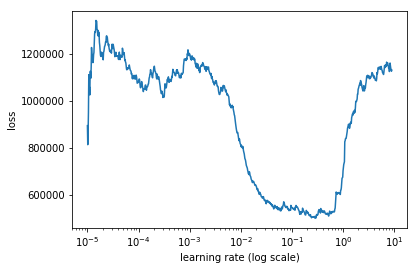

In [25]:
# set to true to try learning rate finder
if True:
    learn.save('tmp')
    lrf=learn.lr_find()
    learn.sched.plot(0)
    learn.load('tmp')

In [27]:
lr = 0.0015
learn.fit(lr, 4, cycle_len=5, use_clr=(32,5), best_save_name='liver_mse_best_1', metrics=[cindex_metric])
learn.save('liver_mse_1')

HBox(children=(IntProgress(value=0, description='Epoch', max=20), HTML(value='')))

 21%|██▏       | 192/894 [00:07<00:26, 26.58it/s, loss=4.8e+05] 

Exception in thread Thread-8:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.6/dist-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/usr/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   cindex_metric                  
    0      485354.931295 510337.782997 0.523801  
    1      490698.702549 526657.53125 0.521294                  
    2      483611.310494 515818.12335 0.519937                  
    3      465645.700428 504705.264109 0.520707                 
    4      491576.835927 511887.20461 0.520721                  
    5      427831.973362 504395.292744 0.522261                 
    6      489709.727315 544702.288062 0.522136                 
    7      483192.945115 518282.89408 0.520704                  
    8      462326.066705 520236.749066 0.523799                 
    9      481763.045106 514125.032642 0.522035                 
    10     451643.084486 535328.773202 0.524451                 
    11     467981.683479 554817.839419 0.521838                 
    12     438877.119805 499398.635249 0.522                    
    13     446777.657714 502148.600291 0.523038                 
    14     436969.736671 496076.910212 0

In [28]:
lrs = np.array([lr/1000, lr/100, lr])
learn.freeze_to(-2) #unfreeze res and head layers
learn.fit(lrs, 10, cycle_len=10, use_clr=(32,10), best_save_name='liver_mse_best_2', metrics=[cindex_metric])
learn.save('liver_mse_2')

HBox(children=(IntProgress(value=0, description='Epoch'), HTML(value='')))

epoch      trn_loss   val_loss   cindex_metric                  
    0      459779.657454 508971.343786 0.517869  
    1      437328.338126 557673.740342 0.519152                 
    2      413561.578415 1496211.916139 0.52155                 
    3      422041.258591 8347342.050601 0.525324                
    4      424271.842902 5389901.284135 0.539144                
    5      429283.167787 11204715.256206 0.536591               
    6      394898.466423 1432143.74582 0.538557                 
    7      384770.520522 2879471.990982 0.542441                
    8      396585.192991 2403799.339287 0.544608                
    9      380744.124694 7853229.808903 0.54461                 
    10     393129.822739 5771018.495971 0.551641                
    11     385848.092781 2249043.121069 0.551906                
    12     343315.175917 802383.530125 0.550982                 
    13     371060.84701 1206345.583808 0.551063                 
    14     340362.21393 5085726.907286 0

In [29]:
lrs = np.array([lr/1000, lr/100, lr])
learn.unfreeze() #unfreeze all types, including conv layers
learn.fit(lrs, 10, cycle_len=10, use_clr=(32,10), best_save_name='liver_mse_best_3', metrics=[cindex_metric])
learn.save('liver_mse_3')

HBox(children=(IntProgress(value=0, description='Epoch'), HTML(value='')))

epoch      trn_loss   val_loss   cindex_metric                  
    0      194742.113985 20013224.552988 0.577507  
    1      192040.617846 2180219.456011 0.580901                
    2      192595.860793 13948159.219851 0.591775               
    3      183206.376124 3317289.047942 0.593221                
    4      177144.539681 9136432.947498 0.588163                
    5      148883.857953 8927923.977883 0.589323                
    6      156557.81924 20149045.612037 0.59446                 
    7      140521.81732 1211967.711284 0.589393                 
    8      152310.949348 2254519.009689 0.591625                
    9      147698.099458 3020096.262857 0.595302                
    10     179066.110159 1139858.014567 0.593023                
    11     164104.909762 6764653.223332 0.591386                
    12     145671.285908 2690141.976629 0.592763                
    13     151319.934132 6935018.245664 0.589258                
    14     140410.953964 4250831.82349

In [31]:
from torch.autograd import Variable
def eval_model(learn, model_name):
    learn.save('tmp')
    learn.load(model_name)
    y_pred, y_targ = learn.predict_with_targs()
    learn.load('tmp')
#    return learn.crit(T(y_pred), T(y_targ)), cindex_metric(y_pred, y_targ)
    crit_data = learn.crit(Variable(T(y_pred)),Variable(T(y_targ))).data[0]
    return crit_data,cindex_metric(y_pred, y_targ)

In [32]:
for mname in ['liver_mse_1', 'liver_mse_best_1'
              ,'liver_mse_2', 'liver_mse_best_2'
              ,'liver_mse_3', 'liver_mse_best_3'
             ]:
    print(mname,eval_model(learn, mname))

liver_mse_1 (625609.125, 0.5874257140371368)
liver_mse_best_1 (527207.0, 0.5902777338977413)
liver_mse_2 (5538652.0, 0.779573840973883)
liver_mse_best_2 (5538652.0, 0.779573840973883)
liver_mse_3 (63724900.0, 0.8314227496483081)
liver_mse_best_3 (25991572.0, 0.8290818568397568)


In [33]:
learn.load('liver_mse_best_3')

In [34]:
y_pred = learn.predict_dl(md_test.val_dl)
test_df = test_csv_df.copy()
test_df['y_pred'] = y_pred

y_pred.shape, test_df.shape

((950, 1), (950, 6))

In [35]:
yp_pred = test_df.groupby('patient_id').y_pred.min()
yp_targ = test_df.groupby('patient_id').val.mean()

In [36]:
concordance_index(yp_pred, yp_targ )

0.5244755244755245

In [37]:
learn.crit(Variable(T(yp_pred)), Variable(T(yp_targ)))

Variable containing:
1.00000e+06 *
  1.4039
[torch.cuda.FloatTensor of size 1 (GPU 1)]

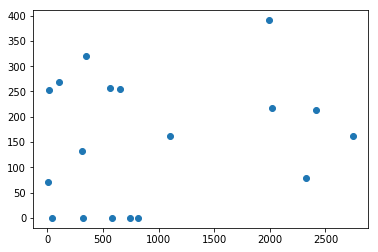

In [38]:
scatter(yp_targ, yp_pred)

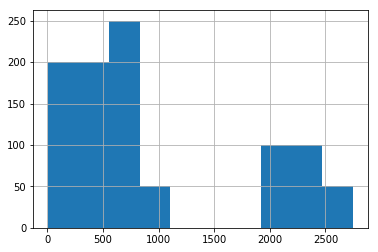

In [39]:
test_df.val.hist()

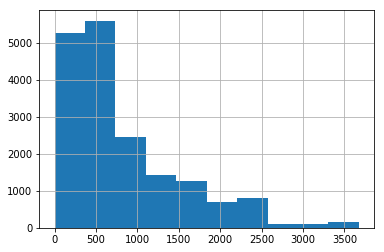

In [40]:
train_csv_df.val.hist()

In [41]:
y_pred = learn.predict_dl(md_test.val_dl)

In [42]:
out = next(iter(md_test.val_dl))


In [43]:
out[0].size()

torch.Size([16, 3, 256, 256])

In [44]:
out[1]


  322
  322
  322
  322
  322
  322
  322
  322
  322
  322
  322
  322
  322
  322
  322
  322
[torch.cuda.FloatTensor of size 16x1 (GPU 1)]

In [45]:
test_df.groupby('patient_id').y_pred.count()

patient_id
TCGA-5C-A9VH     50
TCGA-BC-A10R    100
TCGA-BC-A8YO     50
TCGA-CC-5262     50
TCGA-CC-A8HU     50
TCGA-DD-A1EB     50
TCGA-DD-A4ND     50
TCGA-DD-A4NI     50
TCGA-DD-A73E     50
TCGA-DD-AACB     50
TCGA-DD-AACK     50
TCGA-DD-AADM     50
TCGA-DD-AAW1     50
TCGA-FV-A2QR     50
TCGA-G3-A25Z     50
TCGA-MI-A75H     50
TCGA-RG-A7D4     50
TCGA-ZS-A9CF     50
Name: y_pred, dtype: int64

In [46]:
preds = learn.predict()

In [47]:
preds.shape

(3514, 1)

In [48]:
preds[:10]

array([[288.1973 ],
       [696.7984 ],
       [559.4727 ],
       [907.321  ],
       [764.2301 ],
       [689.4082 ],
       [855.73364],
       [614.3366 ],
       [537.2747 ],
       [510.63712]], dtype=float32)

In [49]:
md.val_ds.n

3514

724.0
724.0
724.0
724.0


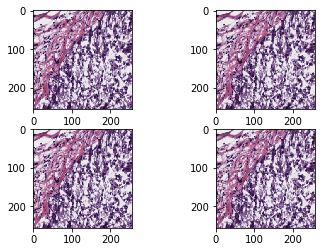

In [50]:

for kk in range(4):
    out = next(iter(md.val_ds))
    out_img = md.trn_ds.denorm(out[0])
    print(out[1][0])
    plt.subplot(2,2,kk+1)
    plt.imshow(out_img.squeeze())
           